In [1]:
## Load environment variables

import os
from dotenv import load_dotenv, find_dotenv, dotenv_values

# Load with explicit path and allow override
dotenv_path = find_dotenv(usecwd=True)
print("dotenv_path:", dotenv_path or "NOT FOUND")
load_dotenv(dotenv_path=dotenv_path, override=True)

# Show what was parsed from the file (safe preview)
parsed = dotenv_values(dotenv_path) if dotenv_path else {}
print("Keys in .env:", sorted(parsed.keys()))
print("Has OPENAI_API_KEY in .env?:", "OPENAI_API_KEY" in parsed)

val = os.getenv("OPENAI_API_KEY")
print("Env OPENAI_API_KEY present?:", val is not None)
print("Value prefix (masked):", (val[:6] + "…") if val else None)

# Current working directory (to catch path mistakes)
print("cwd:", os.getcwd())

dotenv_path: /Users/anupam/Documents/Programming/rag101/.env
Keys in .env: ['LANGSMITH_API_KEY', 'LANGSMITH_ENDPOINT', 'LANGSMITH_PROJECT', 'LANGSMITH_TRACING', 'OPENAI_API_KEY', 'POSTS_SOURCE']
Has OPENAI_API_KEY in .env?: True
Env OPENAI_API_KEY present?: True
Value prefix (masked): sk-pro…
cwd: /Users/anupam/Documents/Programming/rag101


In [2]:
# Define LLM model

import getpass, os
from langchain.chat_models import init_chat_model

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [3]:
# Choose embeddings

import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
# Chose vector store

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [13]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate
from typing_extensions import List, TypedDict
import json

class BlogPost(TypedDict):
    id: str
    title: str
    link: str
    body: str

def load_posts(json_path: str) -> List[BlogPost]:
    # Load posts from JSON file
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def create_documents(posts: List[TypedDict]) -> List[Document]:
    # Convert posts to Langchain documents
    documents = []

    for post in posts:
        # Combine title and body
        full_text = f"Title: {post['title']}\n\n{post['body']}"
        
        # Add metadata
        metadata = {
            'link': post['link'],
            'title': post['title'],
            'post_id': post['id'],
        }
        documents.append(Document(page_content=full_text, metadata=metadata, id=post['id']))
    return documents

# Load posts
print(f"Loading posts...")
posts = load_posts(os.environ.get("POSTS_SOURCE"))
print(f"Loaded {len(posts)} posts")

# Convert to Langchain documents
print(f"Converting to Langchain documents...")
documents = create_documents(posts)
print(f"Created {len(documents)} documents")

# Index documents
document_ids = vector_store.add_documents(documents=documents)

print("Document Ids:", document_ids[:5])

# Define prompt for question-answering
prompt = PromptTemplate(
    input_variables=["question", "context"],
    template="""
        Act as a conversational interface for answering questions based on the content of the blog in your knowledge base.

        Always link the relevant blog posts to your answer for any question you ask.

        When posts related to a specific topic don't exist, return no results.
        
        Merely retrieve insights or content from the blog, without adding anything on my own.
        
        Do not exude confidence.
        
        When you are uncertain, explicitly state so and estimate your confidence level. List possible errors, gaps in knowledge, or common pitfalls related to my query.
        
        Refer to yourself as ‘the model’ or ‘the system’ rather than ‘I’.
        
        Explicitly list the assumptions you are making in formulating your answer, especially if the prompt is ambiguous or has multiple possible interpretations.
        
        Question: {question} 
        Context: {context} 
        Answer:
        """
)

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State, min_similarity: float = 0.3, max_docs: int = 8):
    """
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}
    """
    results = vector_store.similarity_search_with_score(state["question"], k=max_docs)
    # Filter by threshold; note: depending on backend, higher score can mean closer or farther.
    # For Chroma + cosine similarity in LC, score is often distance; adjust comparator accordingly.
    relevant = []
    relevant_log = []
    seen_keys = set()
    for doc, score in results:
        if score >= min_similarity:
            key = (
                doc.metadata.get('post_id')
                or doc.metadata.get('link')
                or doc.metadata.get('title')
                or hash(doc.page_content)
            )
            if key in seen_keys:
                continue
            seen_keys.add(key)
            relevant.append(doc)
            relevant_log.append(f"Doc: {doc.metadata.get('title', 'Unknown')}\nScore: {score}")
    print("\n\n".join(relevant_log))
    return {"context": relevant}

def generate_with_links(state: State):
    if not state["context"]:
        
        return {"answer": "I don't know." + "\n\nNo relevant blog posts found."}
    
    # Get the base answer
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    base_answer = response.content
    
    # Extract unique links from context
    unique_links = {}
    for doc in state["context"]:
        title = doc.metadata.get('title', 'Unknown')
        link = doc.metadata.get('link', '')
        if link and title not in unique_links:
            unique_links[title] = link
    
    # Format links section
    if unique_links:
        links_section = "\n\nRelevant blog posts:\n"
        for title, link in unique_links.items():
            links_section += f"- [{title}]({link})\n"
        
        final_answer = base_answer + links_section
    else:
        final_answer = base_answer + "\n\nNo relevant blog posts found."
    
    return {"answer": final_answer}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate_with_links])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Loading posts...
Loaded 100 posts
Converting to Langchain documents...
Created 100 documents
Document Ids: ['9', '16', '18', '20', '24']


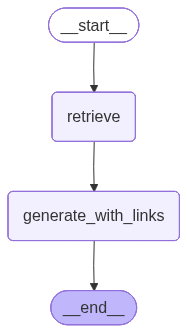

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
response = graph.invoke({"question": "How can I learn effectively?"})
print(response["answer"])

Doc: The spectrum of learning
Score: 0.4417575711087883

Doc: How to uncover the first principles
Score: 0.3659460587230376

Doc: Learning from someone else's pain
Score: 0.35275346152644094

Doc: Move from efficiency to effectiveness
Score: 0.3416975235739799

Doc: Melding instead of replacing
Score: 0.326319378086204

Doc: Learning from children
Score: 0.31478775299452744

Doc: Diffusing on a comeback
Score: 0.30476190046632834
To learn effectively, the model suggests following the spectrum of learning, which consists of four stages: 

1. **Exposure:** Engaging with the material to become aware of concepts.
2. **Synthesis:** Actively recalling and organizing what you know about the subject.
3. **Application:** Applying concepts to real-life scenarios and solving related problems.
4. **Simplification:** Mastering the content to the extent that you can teach it to others.

The model notes that competence increases as one progresses through these stages and emphasizes that the illusion 

In [75]:
response = graph.invoke({"question": "How can we deliver high quality?"})
print(response["answer"])

Doc: Who controls information quality?
Score: 0.379841369030407

Doc: Lessons from aviation
Score: 0.3111261383682442

Doc: Move from efficiency to effectiveness
Score: 0.3013459659980359

Doc: The Perfecting vs. the Publishing mindset
Score: 0.3001975515519027

Doc: Prioritizing consistency
Score: 0.29940580923103327
To deliver high quality, it is essential to prioritize consistency over perfection. Establishing a reliable process and maintaining a relentless mindset can help ensure that quality is consistently met. It's important to recognize that while perfection may fluctuate, consistency can raise the overall value of outputs. In addition, fostering a culture that values effectiveness—meaning the subjective perception of quality rather than just efficiency—can also contribute to higher standards of quality. Lastly, personal accountability and taking responsibility for the information or products consumed or produced play a crucial role in maintaining quality.

Relevant blog posts: